In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import tensorflow as tf
import numpy as np

import cv2
from matplotlib import pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from ImageServer import ImageServer
from models_old import emoDAN

In [5]:
datasetDir = "/home/workspace/itautkute/EmotionalDAN/data/"
trainSet = np.load(datasetDir + "AffectnetTrain_7.npz")
initLandmarks = trainSet['Landmark'][0].reshape((1,136))
modelPath = './Model2/Model2'

In [6]:
img_mean = trainSet['ImgMean']
img_std = trainSet['ImgStd']

In [7]:
print(np.mean(img_mean))
print(np.mean(img_std))

0.49033085
0.22473559


In [8]:
validationSet = np.load(datasetDir + "Test_CK_224_7.npz")
Xvalid = validationSet['Image']
Yvalid = validationSet['Landmark']
Yvalid_em = validationSet['Emotion']

In [41]:
val_mean = validationSet['ImgMean']
val_std = validationSet['ImgStd']

In [11]:
emotionDict7 = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}
emotionDict3 = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [12]:
dan = emoDAN(initLandmarks, 50)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Restoring parameters from a pretrained model

In [13]:
sess = tf.Session()
Saver = tf.train.Saver()
Saver.restore(sess,modelPath)

INFO:tensorflow:Restoring parameters from ./Model2/Model2


### Testing

In [48]:
def testExample(image, true_label):
    landm, emt = sess.run(
        [dan['S2_Ret'],
         dan['Pred_emotion']],
        {dan['InputImage']:image,                   
         dan['S1_isTrain']:False,
        dan['S2_isTrain']:False})
    print('Predicted emotion:', emotionDict7[emt[0]])
    print('True emotion', emotionDict7[true_label])
    x_s = landm[0][0:][::2]
    y_s = landm[0][1:][::2]
    img = np.reshape(image[0], (224, 224))
    plt.imshow(img, cmap='gray')
#     shown_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(shown_img)
    for x, y in zip(x_s, y_s):
        plt.scatter([x],[y])

In [62]:
def predict_emotion(image):
    landm, emt = sess.run(
        [dan['S2_Ret'],
         dan['Pred_emotion']],
        {dan['InputImage']:[image],                   
         dan['S1_isTrain']:False,
        dan['S2_isTrain']:False})
    return emotionDict7[emt[0]]

In [49]:
from sklearn.metrics import confusion_matrix
import sklearn

def accuracyOnTestSet(images, labels):
    preds = []
    for img, lbl in zip(images,labels):
        pred_landm, pred_emot = sess.run([dan['S2_Ret'],
                                        dan['Pred_emotion']],
                                        {dan['InputImage']:[img],
                                        dan['S1_isTrain']:False,
                                        dan['S2_isTrain']:False})
        preds.append(pred_emot[0])
    
    

    print(confusion_matrix(labels, preds))
    return sklearn.metrics.accuracy_score(labels, preds)

-0.63596123
Predicted emotion: Anger
True emotion Anger


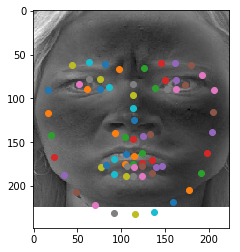

In [50]:
indx = 53

print(np.mean(Xvalid[indx]))

testExample([Xvalid[indx]], Yvalid_em[indx])

1.0328223
Predicted emotion: Anger
True emotion Disgust


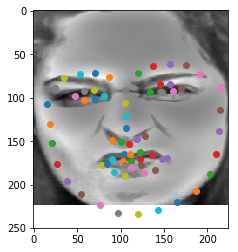

In [43]:
indx = 44

print(np.mean(Xvalid[indx]))

testExample([Xvalid[indx]], Yvalid_em[indx])

In [ ]:
accuracyOnTestSet(Xvalid, Yvalid_em)

### Test on custom image

In [51]:
def test_image(filename):
    input_img = cv2.imread(filename)
#     input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(input_img_gray, (224,224))
    image_vec = np.array(img_resized).astype(np.float32).reshape((-1,224,224,1)) / 255.0
    image_vec = (image_vec - img_mean) / img_std
    landm, emt = sess.run([dan['S2_Ret'], dan['Pred_emotion']],
                                       {dan['InputImage']:image_vec,
                                        dan['S1_isTrain']:False,
                                        dan['S2_isTrain']:False})
    print('Emotion:', emotionDict7[emt[0]])
    x_s = landm[0][0:][::2]
    y_s = landm[0][1:][::2]
    img = np.reshape(image_vec, (224, 224))
    print(np.mean(img))
    shown_img = cv2.resize(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB), (224,224))
    plt.imshow(shown_img)
    for x, y in zip(x_s, y_s):
        plt.scatter([x],[y])
    plt.show()

Emotion: Sadness
0.22639099


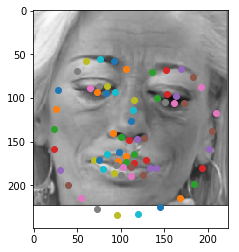

In [34]:
test_image('test.jpg')

Emotion: Happiness
-0.094062544


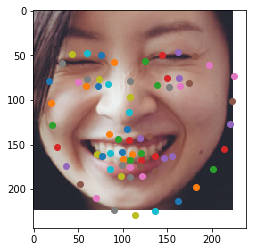

In [40]:
test_image('happy.jpg')

Emotion: Neutral
0.01757084


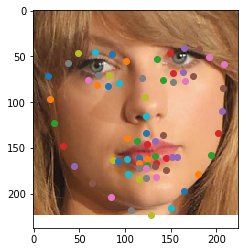

In [35]:
test_image('sad.jpg')

Emotion: Happiness
0.4868132


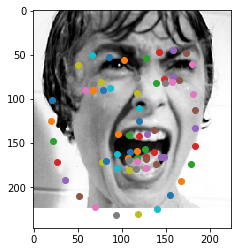

In [36]:
test_image('fear.jpg')

Emotion: Happiness
0.4868132


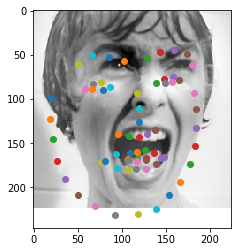

In [18]:
test_image('fear.jpg')

## GradCam 

In [53]:
def target_category_loss(x, class_vector):
    return tf.multiply(x, class_vector)

def target_category_loss_output_shape(input_shape):
    return input_shape

def deprocess_input(x):
    x[:, :, :, 0] += 103.939
    x[:, :, :, 1] += 116.779
    x[:, :, :, 2] += 123.68
    return x

In [55]:
from grad_cam import GradCam

In [57]:
import sys

In [63]:
preprocessed_input = Xvalid[indx]

In [65]:
predicted_class = predict_emotion(preprocessed_input)

In [ ]:
gradcam = GradCam(model, 7, 'block5_conv3')